<a href="https://colab.research.google.com/github/wujj0326/COVID_Risk_Competition/blob/master/COVID_Risk_Score_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from datetime import datetime
from keras.models import load_model
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.set_random_seed(RANDOM_SEED)

## Data Preparation

In [ ]:
risk = pd.read_csv('https://raw.githubusercontent.com/wujj0326/COVID_Risk_Competition/master/Data/risk_confirmed.csv')
# get the places in risk data to merge the data correctly
la_place_risk = list(risk['City'].values)

In [3]:
def get_la_cases():
  url = 'https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-place-totals.csv'
  cases = pd.read_csv(url)
  cases = cases[cases['county']=='Los Angeles'][['date','place','confirmed_cases']]
  # extract the places that are in both risk data and case data
  cases = cases[cases['place'].isin(la_place_risk)]

  result = cases.copy()
  result['date'] = pd.to_datetime(result['date'])
  result = result.sort_values(by=['place','date']).reset_index(drop = True)

  return result

In [4]:
# get the cumulative cases in order to do LSTM prediction
def cum_place_cases(place_name):
  df = get_la_cases()
  df = df[df['place']==place_name]
  df['cum_cases'] = df['confirmed_cases'].cumsum()
  df.set_index('date', inplace=True)
  return df

In [5]:
# get the list of places that are in both risk and case data
def get_places():
  x = get_la_cases()
  places = list(set(x['place'].values))
  return places

## LSTM Prediction

In [6]:
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)

This is the LSTM prediction for every city in the list. It might take about 20 mins

In [7]:
temp = []
places = get_places()
for place in places:

  print('Model for {} starts'.format(place))
  df = cum_place_cases(place)
  df = df.loc[:,['cum_cases']]
  
  x = len(df)-5
  train = df.iloc[:x]
  test = df.iloc[x:]
  
  scaler = MinMaxScaler()
  scaler.fit(train)
  scaled_train = scaler.transform(train)
  scaled_test = scaler.transform(test)
  generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)
  
  model = Sequential()
  model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
  model.add(Dropout(0.2))
  model.add(Dense(75, activation='relu'))
  model.add(Dense(units=1))
  model.compile(optimizer="adam",loss="mse")
  
  validation_set = []
  validation_set = np.append(scaled_train[-1],scaled_test)
  validation_set = validation_set.reshape(6,1)
  validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)
  
  early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
  
  model.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)
  
  test_prediction = []

  ##last n points from training set
  first_eval_batch = scaled_train[-n_input:]
  current_batch = first_eval_batch.reshape(1,n_input,n_features)
  
  for i in range(len(test)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  
  true_prediction = scaler.inverse_transform(test_prediction)
  
  time_series_array = test.index
  for k in range(0,7):
      time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
  
  df_forecast = pd.DataFrame(columns=["place", "confirmed_predicted"],index=time_series_array)
  df_forecast.loc[:,"confirmed_predicted"] = true_prediction[:,0]
  df_forecast.loc[:,'place'] = place
  df_forecast.loc[:,'increase_case'] = df_forecast['confirmed_predicted'].diff()

  df_forecast = df_forecast.iloc[-7:,:]

  temp.append(df_forecast)

Streaming output truncated to the last 5000 lines.
Epoch 17/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 9.8300e-04
Epoch 18/100
10/10 [==============================] - 0s 7ms/step - loss: 8.7990e-04 - val_loss: 0.0037
Epoch 19/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 20/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0233
Epoch 21/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0370
Epoch 22/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 23/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 2.0220e-04
Epoch 24/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 25/100
10/10 [==============================] - 0s 6ms/step - loss: 8.3812e-04 - val_loss: 0.0072
Epoch 26/100
10/10 [=============

In [82]:
df_pred = pd.concat(temp)

In [83]:
df_pred.head(15)

,place,confirmed_predicted,increase_case
date,,,
2020-08-31,Playa Del Rey,1331.965839,26.171024
2020-09-01,Playa Del Rey,1360.458538,28.492699
2020-09-02,Playa Del Rey,1389.637478,29.178940
2020-09-03,Playa Del Rey,1419.718468,30.080990
2020-09-04,Playa Del Rey,1450.941029,31.222561
2020-09-05,Playa Del Rey,1483.587730,32.646702
2020-09-06,Playa Del Rey,1517.969654,34.381924
2020-08-31,Avalon,317.385513,5.092884
2020-09-01,Avalon,322.841496,5.455982


In [87]:
latest_date = str(df_pred.index.max())[:10]

In [88]:
df_pred.to_csv('prediction_{}.csv'.format(latest_date))

## Get Risk Score

### Get Local Risk Score

In [12]:
risk.head()

,City,confirmed_cases,death_cases,pop2010,avg_traffic,avg_asthma,avg_cardiovascular,avg_poverty,avg_elderly,pop_dens
0,Acton,11,1,53654,1058.69,73.62,11.00,70.81,5.24,120974.0
1,Agoura Hills,35,1,60009,1023.45,77.60,10.95,72.49,5.45,177875.5
2,Alhambra,226,8,112060,1816.86,47.43,7.17,46.00,10.40,551582.0
3,Altadena,157,5,69531,1379.59,34.64,5.34,55.34,10.67,864902.9
4,Arcadia,104,7,70416,1305.56,49.61,6.12,73.43,8.78,755363.9


In [67]:
# normalize the scale by using minmaxscaler
scale_risk = MinMaxScaler(feature_range=(0, 1))
features = scale_risk.fit_transform(risk.iloc[:,3:-1])

feat_sum = np.sum(features, axis=1)

In [68]:
sig_feat = 1/(1 + np.exp(feat_sum)) 
risk['sig_feature'] = sig_feat

In [69]:
risk = risk.loc[:,['City', 'sig_feature']]

In [70]:
risk.head()

,City,sig_feature
0,Acton,0.061844
1,Agoura Hills,0.057020
2,Alhambra,0.058919
3,Altadena,0.101601
4,Arcadia,0.077576


### Get Google Mobility Score

In [17]:
def get_google_mobility():  
  gurl = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=04188f017409e90a"
  google_mobility = pd.read_csv(gurl)
  google_mobility = google_mobility[google_mobility['sub_region_2'] == 'Los Angeles County']
  gmobility = google_mobility[['date','retail_and_recreation_percent_change_from_baseline',
                    'grocery_and_pharmacy_percent_change_from_baseline',
                    'parks_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline',
                    'workplaces_percent_change_from_baseline',
                    'residential_percent_change_from_baseline',]].copy()
  gmobility['date'] = pd.to_datetime(google_mobility['date'])
  gmobility.reset_index(drop=True, inplace=True)
  return gmobility

In [57]:
get_google_mobility()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2828: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,1.0,0.0,13.0,-1.0,-1.0,0.0
1,2020-02-16,4.0,-1.0,27.0,-1.0,0.0,-1.0
2,2020-02-17,7.0,0.0,30.0,-11.0,-32.0,7.0
3,2020-02-18,-1.0,0.0,11.0,2.0,2.0,0.0
4,2020-02-19,-1.0,-1.0,13.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...
188,2020-08-21,-31.0,-12.0,-8.0,-41.0,-41.0,15.0
189,2020-08-22,-33.0,-9.0,-13.0,-38.0,-22.0,8.0
190,2020-08-23,-32.0,-13.0,-5.0,-40.0,-23.0,7.0
191,2020-08-24,-30.0,-15.0,-7.0,-43.0,-41.0,13.0


In [18]:
def get_g_score():
  gmobility = get_google_mobility()
  gmobility.set_index('date',inplace = True)
  g_score = pd.DataFrame(np.sum(gmobility, axis=1), columns=['g_score'])
  return g_score

In [ ]:
gscore = get_g_score()

In [20]:
gscore = gscore.cumsum()

In [21]:
x = len(gscore)-5
train = gscore.iloc[:x]
test = gscore.iloc[x:]

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100,activation="relu",input_shape=(n_input,n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer="adam",loss="mse")

validation_set = []
validation_set = np.append(scaled_train[-1],scaled_test)
validation_set = validation_set.reshape(6,1)
validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)

early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

model.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 0.4348 - val_loss: 0.0035
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1465 - val_loss: 0.0104
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.0175
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0698 - val_loss: 0.0276
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0510 - val_loss: 0.0539
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0345
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0159
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 6.5476e-04
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 4.6515e-04 - val_loss: 7.5343e

In [22]:
g_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)+10):
  current_pred = model.predict(current_batch)[0]
  g_prediction.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_prediction = scaler.inverse_transform(g_prediction)

time_series_array = test.index
for k in range(0,10):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [23]:
g_forecast = pd.DataFrame(columns=["g_true", "g_predicted"],index=time_series_array)
g_forecast.loc[:,"g_predicted"] = true_prediction[:,0]
g_forecast.loc[:,'g_true'] = test['g_score']

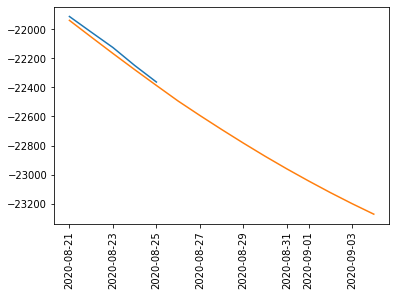

In [24]:
plt.plot(g_forecast)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
g_risk = g_forecast[['g_predicted']].diff()[-7:]

In [60]:
# the larger g_predicted score is the lower the risk. However, larger risk score means high risk in our risk score calculation.
# therefore, we inversed the scale of g_predicted score.
g_risk['g_abs'] = g_risk['g_predicted'].abs()

In [61]:
gscaler = MinMaxScaler(feature_range=(1,2))
gscaled = gscaler.fit_transform(g_risk[['g_abs']])
g_risk['g_scaled'] = gscaled
g_risk

,g_predicted,g_scaled,g_abs
date,,,
2020-08-29,-93.484945,2.000000,93.484945
2020-08-30,-90.461411,1.857330,90.461411
2020-08-31,-86.640217,1.677021,86.640217
2020-09-01,-82.919682,1.501462,82.919682
2020-09-02,-79.848050,1.356523,79.848050
2020-09-03,-76.040079,1.176838,76.040079
2020-09-04,-72.292437,1.000000,72.292437


### Merge data

In [93]:
df_pred_for_merged = df_pred.reset_index()
temp_merged = df_pred_for_merged.merge(risk, how = 'inner', left_on = 'place', right_on = 'City')
risk_merged = temp_merged.merge(g_risk, how = 'inner', left_on = 'date', right_index = True)

In [94]:
risk_merged.head()

,date,place,confirmed_predicted,increase_case,City,sig_feature,g_predicted,g_scaled,g_abs
0,2020-08-31,Playa Del Rey,1331.965839,26.171024,Playa Del Rey,0.305589,-86.640217,1.677021,86.640217
7,2020-08-31,Avalon,317.385513,5.092884,Avalon,0.065107,-86.640217,1.677021,86.640217
14,2020-08-31,West Hills,31164.740718,471.578227,West Hills,0.156492,-86.640217,1.677021,86.640217
21,2020-08-31,Pacoima,179549.113548,2343.233586,Pacoima,0.042712,-86.640217,1.677021,86.640217
28,2020-08-31,Duarte,29328.787192,508.084677,Duarte,0.084619,-86.640217,1.677021,86.640217


In [95]:
risk_merged['risk_score'] = risk_merged['increase_case'] * risk_merged['sig_feature'] * risk_merged['g_scaled']

In [96]:
risk_merged.head()

,date,place,confirmed_predicted,increase_case,City,sig_feature,g_predicted,g_scaled,g_abs,risk_score
0,2020-08-31,Playa Del Rey,1331.965839,26.171024,Playa Del Rey,0.305589,-86.640217,1.677021,86.640217,13.412102
7,2020-08-31,Avalon,317.385513,5.092884,Avalon,0.065107,-86.640217,1.677021,86.640217,0.556074
14,2020-08-31,West Hills,31164.740718,471.578227,West Hills,0.156492,-86.640217,1.677021,86.640217,123.761181
21,2020-08-31,Pacoima,179549.113548,2343.233586,Pacoima,0.042712,-86.640217,1.677021,86.640217,167.842188
28,2020-08-31,Duarte,29328.787192,508.084677,Duarte,0.084619,-86.640217,1.677021,86.640217,72.101464


### Get Final Score

In [ ]:
# temp_risk = []
# for place in places:
#   df = risk_merged[risk_merged['place']==place]
#   df['new_score'] = df['risk_score'].diff()
#   df = df.iloc[1:,:]
#   temp_risk.append(df)

# final = pd.concat(temp_risk)

In [ ]:
# final_scaler = MinMaxScaler(feature_range=(0,10))
# scaled_score = final_scaler.fit_transform(final[['risk_score']])
# final['final_score'] = scaled_score

In [97]:
final_risk = risk_merged.loc[:, ['date','place','risk_score']].sort_values(by = ['place','date']).set_index('date')

In [98]:
final_risk.head(20)

,place,risk_score
date,,
2020-08-31,Acton,7.085892
2020-09-01,Acton,6.622970
2020-09-02,Acton,6.174222
2020-09-03,Acton,5.559903
2020-09-04,Acton,4.921378
2020-08-31,Agoura Hills,13.992419
2020-09-01,Agoura Hills,13.204768
2020-09-02,Agoura Hills,12.169443
2020-09-03,Agoura Hills,10.782147


In [99]:
final_risk.to_csv('final_risk_{}.csv'.format(latest_date))